Welcome to my exploration of red Portuguese vinho verde wines. Vinho verde is a common wine varietal in Portugal known for its light fruity flavor, slight effervescence, and overall drinkability on a warm summer day. While vinho verde is most commonly known for its white version, a red version also exists, and it is into these wines that we will delve. This data set comes from a 2009 publication by Cortez et al titled "Modeling wine preferences by data mining from physicochemical properties." The dataset is widely available on the internet, for example at https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009. To help holistically understand the data better, I rely on Wine Folly (https://winefolly.com/) and some other sources for information about wines.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression


sns.set_palette("bright")

# Import the wine data set
data = pd.read_csv('wineQualityReds.csv', usecols=(np.arange(12)+1))

# Fix outliers in chlorides and residual sugar for better visualization
data["chlorides"] = pd.Series([min(x, 0.14) for x in data["chlorides"]])
data["residual.sugar"] = pd.Series([min(x, 4.) for x in data["residual.sugar"]])
data["total.sulfur.dioxide"] = pd.Series([min(x, 170.) for x in data["total.sulfur.dioxide"]])
data["sulphates"] = pd.Series([min(x, 1.4) for x in data["sulphates"]])

# Add units to the column names
col_names = data.columns
ind_gpdm3 = [0, 1, 2, 3, 4, 9]
col_gpdm3 = [col_names[i] for i in ind_gpdm3]
col_names_units = [name+" (g/dm3)" for name in col_gpdm3]
mgpdm3 = [name+" (mg/dm3)" for name in col_names[5:7]]
col_names_units.insert(5, mgpdm3[0])
col_names_units.insert(6, mgpdm3[1])
col_names_units.insert(7, col_names[7]+" (g/cm3)")
col_names_units.insert(8, col_names[8])
col_names_units.insert(10, col_names[10]+" (%)")
add_units = {col_names[i]: col_names_units[i] for i in range(11)}
data.rename(columns=add_units, inplace=True)

# Scale all the properties to a standard Gaussian distribution.
std_scaler = StandardScaler()
X_cols = data.columns
X = std_scaler.fit_transform(data)
X = pd.DataFrame(X, columns=X_cols)
X["quality"] = data["quality"]

To start, let's look at the columns in the dataset.

In [2]:
print(data.columns)

Index(['fixed.acidity (g/dm3)', 'volatile.acidity (g/dm3)',
       'citric.acid (g/dm3)', 'residual.sugar (g/dm3)', 'chlorides (g/dm3)',
       'free.sulfur.dioxide (mg/dm3)', 'total.sulfur.dioxide (mg/dm3)',
       'density (g/cm3)', 'pH', 'sulphates (g/dm3)', 'alcohol (%)', 'quality'],
      dtype='object')


The list above shows the column names in the data set. The last column, quality, gives the quality score for each wine, as given by a panel of experts who tasted the wine. This is the column that will guide our quest to understand what creates good wine. The first three columns pertain to acid in various ways. The next two columns give us sugar and salt (sodium chloride) values. These are common culinary properties with which most people are familiar. The remaining columns are more wine specific. Sulfur dioxide is common in wines becuase is stabilizes the compounds leading to a more predictable wine; however, sulfur dioxide is also the smell of volcano gas, so care must be taken not to overuse it. pH is another way of measuring the influence of acids on the wine, and density is the mass per volume of the wine, which generally is very close to 1 g/cm3, that of water.

To begin, let's plot histograms of some recognizable columns first to get a feel for the data.

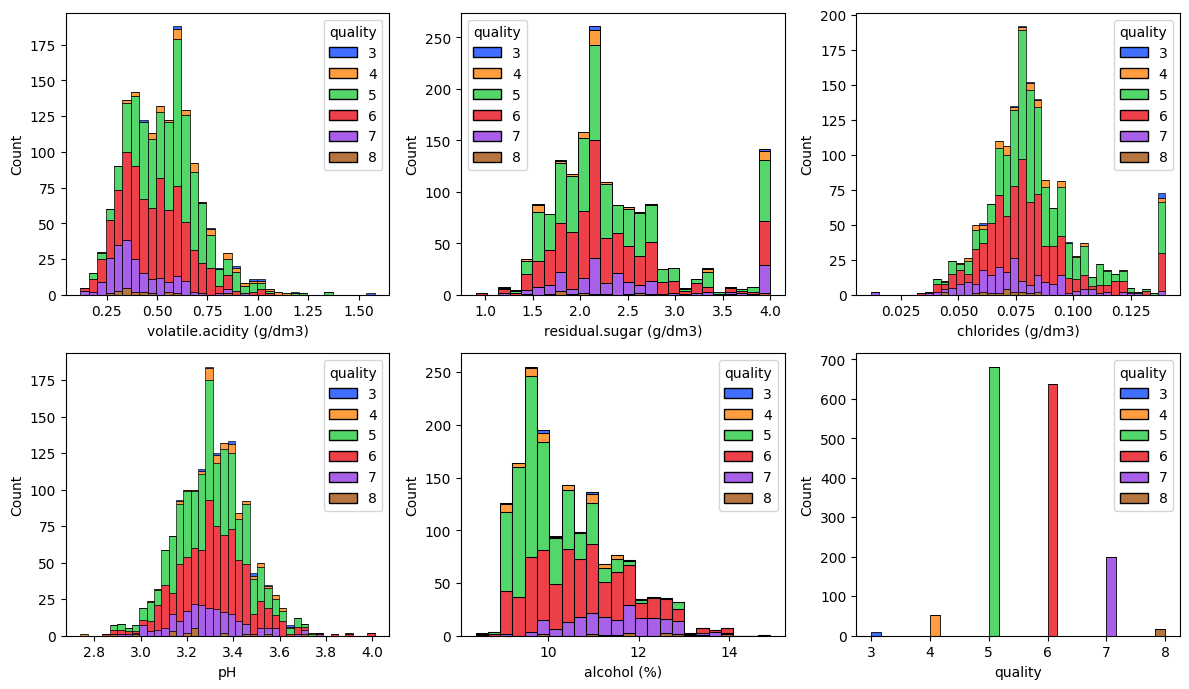

In [3]:
col_names = data.columns
to_plot = [1, 3, 4, 8, 10, 11]
fig, axs = plt.subplots(2,3, figsize=(12,7))
for i in range(6):
    sns.histplot(data=data, x=col_names[to_plot[i]], hue="quality", multiple='stack', palette='bright', ax=axs[i//3, i%3])
fig.tight_layout()

Since the goal of this project is to understand how these properties influence wine quality, the proportion of wines with each quality rating are shown within each histogram bin. Two properties jump out as clearly influencing the quality, volatile acidity and alcohol. Volatile acidity in this case is acetic acid, better known a vinegar. It is not surprising that high quality wines tend to have less vinegar. Alcohol shows the opposite trend, with greater alcohol percentages producing higher quality wines. Infact, the influence on alcohol is so strong that for alcohol percentages above 11.8% we can say the wine quality is almost certain to be 6 or better! Let's now look through the entire data set to see which properties can tell us the most about wine quality. To do this, we'll use mutual information, which is like a quantifying of correlation, but is also sensitive to nonlinear dependencies as well.

In [4]:
def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    #mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

dctry = {i: make_mi_scores(X, data["quality"]) for i in range(20)}
all_scores = pd.DataFrame(dctry)
mi_scores = all_scores.mean(axis=1).sort_values(ascending=False)
print(mi_scores[1:])

alcohol (%)                      0.181119
volatile.acidity (g/dm3)         0.120520
sulphates (g/dm3)                0.103322
density (g/cm3)                  0.086468
total.sulfur.dioxide (mg/dm3)    0.081254
citric.acid (g/dm3)              0.064173
fixed.acidity (g/dm3)            0.049000
chlorides (g/dm3)                0.034340
free.sulfur.dioxide (mg/dm3)     0.022625
pH                               0.021805
residual.sugar (g/dm3)           0.019398
dtype: float64


The higher the mutual information number, the better the predictive power of that proprety. After alcohol and volative acidity, which we discussed above, the next most potent property is the sulphates in the wine. Sulphates are added to wine as stabilizes that prevent wines from going bad. The next-most-useful property is density. Since alcohol and water have slightly different densities, the high mutual information of density is likely due to its inherent dependence on alcohol concentration. To adjust for this, let's subtract the linear dependence of alcohol from density and recompute the mutual information. While we're at it, some foresite to the next property, total sulfur dioxide, suggests a possible dependence on sulphates, so let's do both before we recalculate mutual information.

In [5]:
def remove_correlation(array_base, array_corr):
    m, b, _, _, _ = linregress(array_base, array_corr)
    return  array_corr - (m*array_base + b)

#m, b, _, _, _ = linregress(data["alcohol (%)"], data["density (g/cm3)"])
#lrline = lr.predict(data["alcohol (%)"])
#sns.scatterplot(x=data["alcohol (%)"], y=data["density (g/cm3)"])
#plt.plot(np.linspace(8, 15), density_from_alcohol(np.linspace(8, 15)), 'r')
#plt.plot(np.linspace(8, 15), m*np.linspace(8, 15)+b, 'g')
#plt.show()

data["density.noalc"] = remove_correlation(data["alcohol (%)"], data["density (g/cm3)"])
data["sulfur.dioxide.nosulph"] = remove_correlation(data["sulphates (g/dm3)"], data["total.sulfur.dioxide (mg/dm3)"])


In [6]:
std_scaler = StandardScaler()
X_cols = data.columns
#print(X_cols)
X = std_scaler.fit_transform(data)
X = pd.DataFrame(X, columns=X_cols)
X["quality"] = data["quality"]

dctry = {i: make_mi_scores(X, data["quality"]) for i in range(20)}
all_scores = pd.DataFrame(dctry)
mi_scores = all_scores.mean(axis=1).sort_values(ascending=False)
print(mi_scores[1:])

alcohol (%)                      0.182304
sulfur.dioxide.nosulph           0.152583
volatile.acidity (g/dm3)         0.120267
sulphates (g/dm3)                0.107828
density (g/cm3)                  0.085696
total.sulfur.dioxide (mg/dm3)    0.077292
density.noalc                    0.062719
citric.acid (g/dm3)              0.058325
fixed.acidity (g/dm3)            0.043986
chlorides (g/dm3)                0.035435
free.sulfur.dioxide (mg/dm3)     0.019667
pH                               0.018751
residual.sugar (g/dm3)           0.014285
dtype: float64


Our observation proved prescient that density was hiding information about alcohol content in it, as the new property, "density.noalc" has lower mutual information with quality than the original density. However, the new total sulfur dioxide, "sulfur.dioxide.nosulph" has higher mutual information than the original. This is unexpected, and suggests a nonlinear relationship is at play, and/or that perhaps total sulfur dioxide was not hiding much information about sulphates in it. To take stock of what we've found so far, let's plot histograms of the 4 proprties that tell us the most about quality.

Index(['fixed.acidity (g/dm3)', 'volatile.acidity (g/dm3)',
       'citric.acid (g/dm3)', 'residual.sugar (g/dm3)', 'chlorides (g/dm3)',
       'free.sulfur.dioxide (mg/dm3)', 'total.sulfur.dioxide (mg/dm3)',
       'density (g/cm3)', 'pH', 'sulphates (g/dm3)', 'alcohol (%)', 'quality',
       'density.noalc', 'sulfur.dioxide.nosulph'],
      dtype='object')


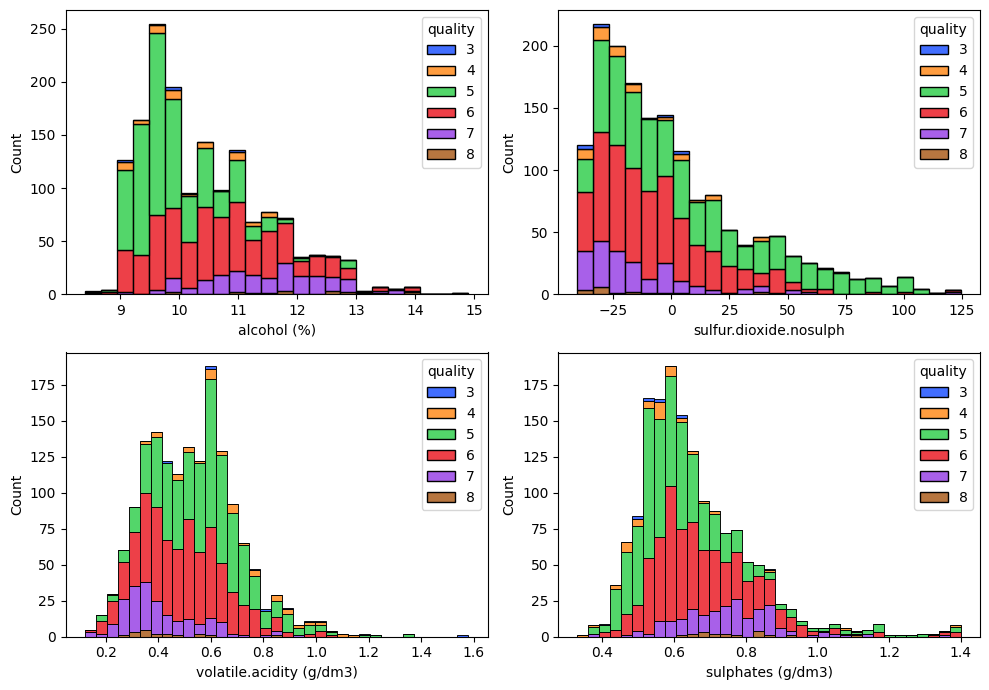

In [7]:
col_names = data.columns
print(col_names)
to_plot = [10, 13, 1, 9]
fig, axs = plt.subplots(2,2, figsize=(10,7))
for i in range(4):
    sns.histplot(data=data, x=col_names[to_plot[i]], hue="quality", multiple='stack', palette='bright', ax=axs[i//2, i%2])
fig.tight_layout()

Based on the above histograms, we can easily conclude that high quality wines in general have high alcohol, low sulfur dioxide, low volatile acidity, and high sulphates. Let's see what we can see if we study only the subset of wines that have each of these characteristics. By eye, I determine that we will look at wines with alcohol > 11 %, sulfur dioxide < 0 mg/dm3 (recall the way this is created the units aren't as physical as for the others), volatile acidity < 0.5 g/dm3, and sulphates > 0.65 g/dm3.

In [35]:
in_vol = 0
out_vol = 0
idx_in1 = []
for i in range(len(data)):
    if (data.loc[i, "alcohol (%)"] > 11.):
        in_vol +=1
        idx_in1.append(i)
    else:
        out_vol += 1
        
print(in_vol, out_vol)

in_vol = 0
out_vol = 0
idx_in2 = []
for i in range(len(data)):
    if ((data.loc[i, "alcohol (%)"] > 11.) 
      and (data.loc[i, "volatile.acidity (g/dm3)"] < 0.5)):
        in_vol +=1
        idx_in2.append(i)
    else:
        out_vol += 1

print(in_vol, out_vol)
        
in_vol = 0
out_vol = 0
idx_in3 = []
for i in range(len(data)):
    if ((data.loc[i, "alcohol (%)"] > 11.) 
      and (data.loc[i, "volatile.acidity (g/dm3)"] < 0.5)
      and (data.loc[i, "sulphates (g/dm3)"] > 0.65)):
        in_vol +=1
        idx_in3.append(i)
    else:
        out_vol += 1
        
print(in_vol, out_vol)       
    
in_vol = 0
out_vol = 0
idx_in4 = []
for i in range(len(data)):
    if ((data.loc[i, "alcohol (%)"] > 11.) 
      and (data.loc[i, "volatile.acidity (g/dm3)"] < 0.5)
      and (data.loc[i, "sulphates (g/dm3)"] > 0.65)
      and (data.loc[i, "sulfur.dioxide.nosulph"] < 0.)):
        in_vol +=1
        idx_in4.append(i)
    else:
        out_vol += 1   
        
print(in_vol, out_vol)    

408 1191
249 1350
149 1450
117 1482


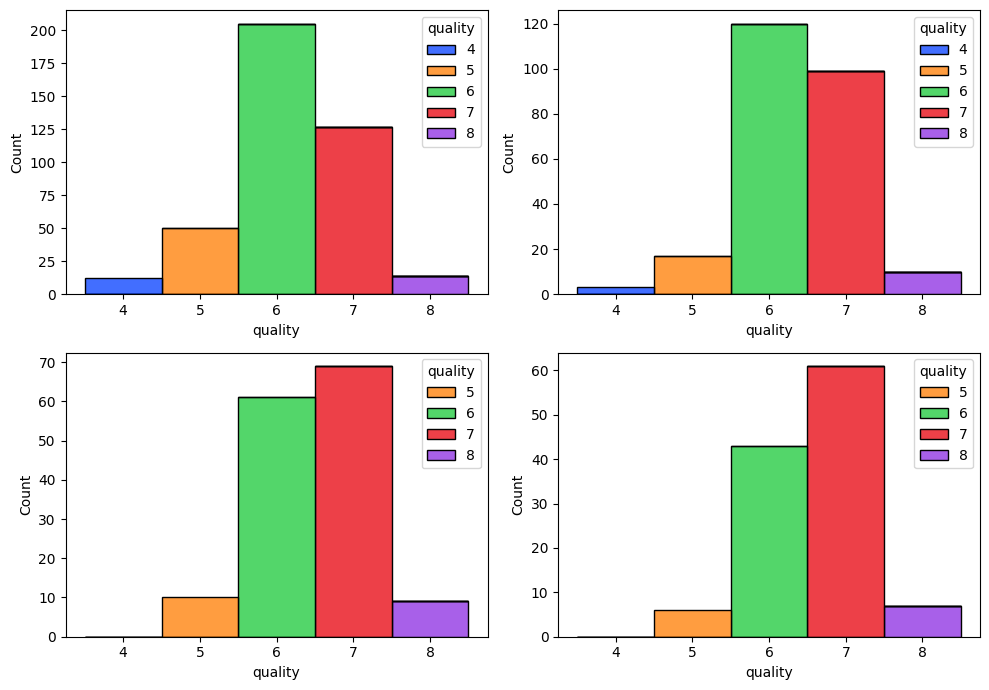

In [42]:
fig, axs = plt.subplots(2,2, figsize=(10,7))
idx_in_list = [idx_in1, idx_in2, idx_in3, idx_in4]
for i in range(4):
    sns.histplot(data=data.loc[idx_in_list[i],:], x="quality", hue="quality", multiple='stack',
                 bins= [3.5, 4.5, 5.5, 6.5, 7.5, 8.5], palette=sns.color_palette("bright")[i//2:i//2+(5-i//2)], ax=axs[i//2, i%2])
fig.tight_layout()

#sns.histplot(data=data.loc[idx_in,:], x="quality", hue="quality", multiple='stack', palette='bright')

We have isolated 117 wines, of which the majority are quality 7 or 8. In the original dataset there were over 200 wines with quality 7 or 8, and we've captured here only about one third of them. Let's explore just these 117 wines quickly.

In [51]:
data_vol = data.loc[idx_in4]
data_vol = data_vol.reset_index()
data_vol.head()

index  fixed.acidity (g/dm3)  volatile.acidity (g/dm3)  \
0    267                    7.9                      0.35   
1    278                   10.3                      0.32   
2    327                   10.3                      0.44   
3    330                   10.2                      0.36   
4    331                   10.2                      0.36   

   citric.acid (g/dm3)  residual.sugar (g/dm3)  chlorides (g/dm3)  \
0                 0.46                     3.6              0.078   
1                 0.45                     4.0              0.073   
2                 0.50                     4.0              0.107   
3                 0.64                     2.9              0.122   
4                 0.64                     2.9              0.122   

   free.sulfur.dioxide (mg/dm3)  total.sulfur.dioxide (mg/dm3)  \
0                          15.0                           37.0   
1                           5.0                           13.0   
2                           5.0                           13.0   
3                          10.0                           41.0   
4                          10.0                           41.0   

   density (g/cm3)    pH  sulphates (g/dm3)  alcohol (%)  quality  \
0           0.9973  3.35               0.86         12.8        8   
1           0.9976  3.23               0.82         12.6        8   
2           0.9980  3.28               0.83         11.5        5   
3           0.9980  3.23               0.66         12.5        6   
4           0.9980  3.23               0.66         12.5        6   

   density.noalc  sulfur.dioxide.nosulph  
0       0.002642              -10.491662  
1       0.002766              -34.262803  
2       0.002200              -34.320018  
3       0.003079               -5.347369  
4       0.003079               -5.347369

In [52]:
std_scaler = StandardScaler()
X_vol_cols = data_vol.columns
#print(X_cols)
X_vol = std_scaler.fit_transform(data_vol)
X_vol = pd.DataFrame(X_vol, columns=X_vol_cols)
X_vol["quality"] = data_vol["quality"]

dctry = {i: make_mi_scores(X_vol, data_vol["quality"]) for i in range(20)}
all_scores = pd.DataFrame(dctry)
mi_scores = all_scores.mean(axis=1).sort_values(ascending=False)
print(mi_scores[1:])

pH                               0.090636
fixed.acidity (g/dm3)            0.083016
residual.sugar (g/dm3)           0.064130
chlorides (g/dm3)                0.045297
volatile.acidity (g/dm3)         0.044732
density.noalc                    0.030200
alcohol (%)                      0.028646
citric.acid (g/dm3)              0.028599
index                            0.028547
density (g/cm3)                  0.012839
sulphates (g/dm3)                0.006906
total.sulfur.dioxide (mg/dm3)    0.004047
sulfur.dioxide.nosulph           0.003848
free.sulfur.dioxide (mg/dm3)     0.003846
dtype: float64


In [ ]:
# Nothing more 'good' below here.

<AxesSubplot:xlabel='total.sulfur.dioxide (mg/dm3)', ylabel='quality'>

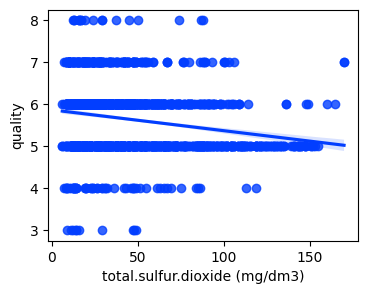

In [10]:
#sns.set(rc={"figure.figsize":(4, 3)}) #width=3, #height=4
plt.figure(figsize=(4,3))
sns.regplot(x=data["total.sulfur.dioxide (mg/dm3)"], y=data["quality"])

<AxesSubplot:xlabel='total.sulfur.dioxide (mg/dm3)', ylabel='sulphates (g/dm3)'>

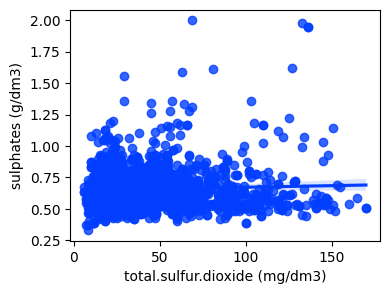

In [15]:
plt.figure(figsize=(4,3))
sns.regplot(x=data["total.sulfur.dioxide (mg/dm3)"], y=data["sulphates (g/dm3)"])

<AxesSubplot:xlabel='sulfur.dioxide.nosulph', ylabel='sulphates (g/dm3)'>

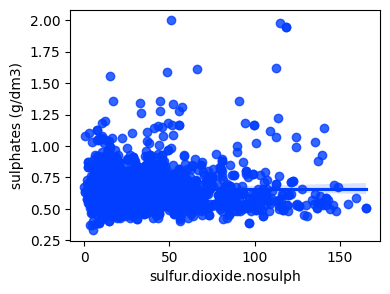

In [12]:
plt.figure(figsize=(4,3))
sns.regplot(x=data["sulfur.dioxide.nosulph"], y=data["sulphates (g/dm3)"])

<AxesSubplot:xlabel='sulfur.dioxide.nosulph', ylabel='Count'>

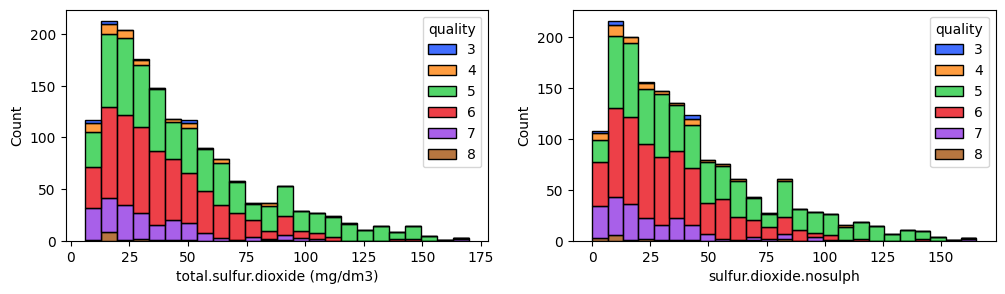

In [13]:
fig, axs = plt.subplots(1,2, figsize=(12,3))
sns.histplot(data=data, x="total.sulfur.dioxide (mg/dm3)", hue="quality", multiple='stack', palette='bright', ax=axs[0])
sns.histplot(data=data, x="sulfur.dioxide.nosulph", hue="quality", multiple='stack', palette='bright', ax=axs[1])

<AxesSubplot:xlabel='density.noalc', ylabel='alcohol (%)'>

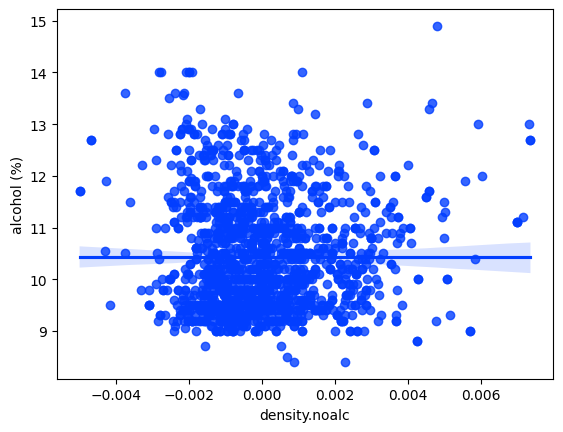

In [34]:
sns.regplot(x=data["density.noalc"], y=data["alcohol (%)"])

Since the first 5 columns lend themselves best to intuition based on common culinary experiences, everything from drinking lemonande to cooking steak, let's start our analysis there! To get a sense of the typical values and and their relationship to quality, I made histograms of the individual column values, and the qaulity of wines with those values is shown by colors. I have also slightly modified the sugar and salt columns for outliers, which you can see more about in my fitting notebook.

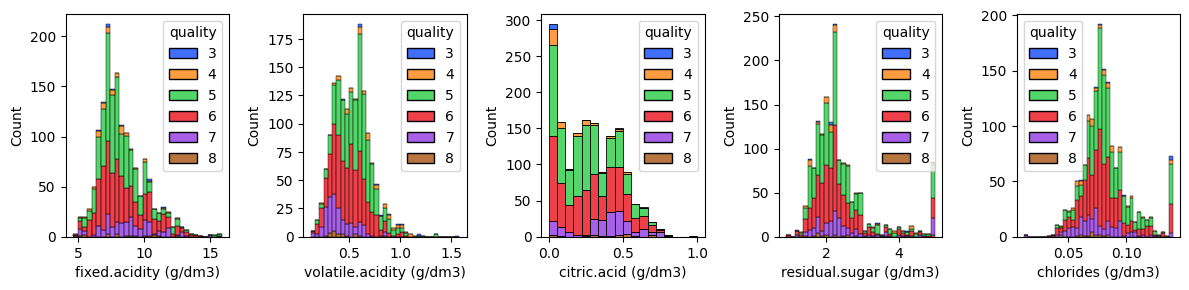

In [3]:
col_names = data.columns
fig, axs = plt.subplots(1,5, figsize=(12,3))
for i in range(5):
    sns.histplot(data=data, x=col_names[i], hue="quality", multiple='stack', palette='bright', ax=axs[i%5])
fig.tight_layout()

Acids can be very culinarily polarizating. Think about the difference between sucking on a lemon, versus putting a splash of lemon juice in your glass of water, versus drinking a Coke. You wouldn't want to suck on the lemon, but you probably would enjoy the Coke. Why? Because the lemon tastes way too sour and acidic! But, by some measures, the Coke actually has more acid. How then is Coke palatable enough to spur the creation of an almost-300B$ company while nobody consumes lemon juice without majorly diluting it first? The answer, conveniently, lies in the use of sugar and salt. But, then if lemon juice is so unpalatable, why does Coca-Cola own Minute Maid, a lemonade that touts itself as "made with real lemons?" This also has to do with copious amounts of sugar, but also the wonderful taste associated with citric acid. Yes, the same citric acid present in our vinho verde wines! And, lest you think that adding sugar and salt to any acid will create a delishious beverage, consider the last time you vinegar-ade. Probably never. And for good reason. Vinegar, or acetic acid, is volatile, and that quantity is respresented by the volatile acidity. Finally, fixed acid, in this case tartaric acid, both stabilizes the wine and provides flavor. Tartaric acid is most prevalent in grapes, but also occurs naturally in avocado apricot, and tamarind. When determining wine quality, we can cearly see from the plots above that fixed and volatile acidity correlate with wine quality. 

<AxesSubplot:xlabel='quality', ylabel='volatile.acidity (g/dm3)'>

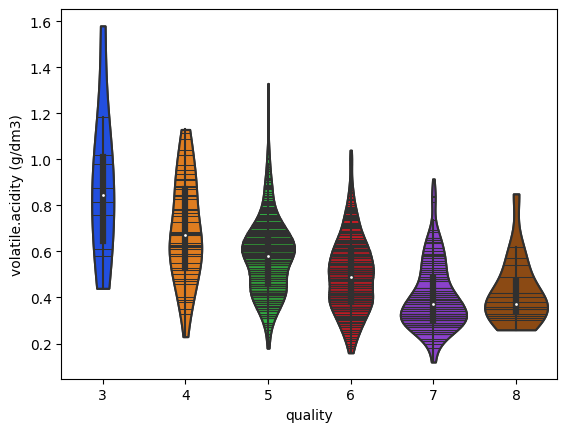

In [4]:
sns.violinplot(data=data, x="quality", y="volatile.acidity (g/dm3)", cut=0)
sns.violinplot(data=data, x="quality", y="volatile.acidity (g/dm3)", cut=0, inner="stick")

<AxesSubplot:xlabel='quality', ylabel='citric.acid (g/dm3)'>

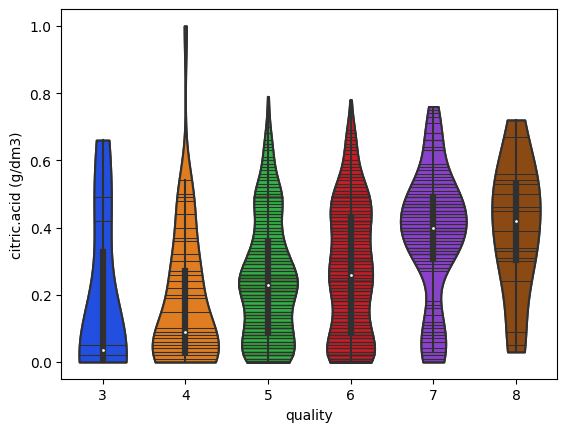

In [5]:
sns.violinplot(data=data, x="quality", y="citric.acid (g/dm3)", cut=0, scale="area", inner="box")
sns.violinplot(data=data, x="quality", y="citric.acid (g/dm3)", cut=0, scale="area", inner="stick")

The two violin plots of the volatile acidity, vinegar; and citric acid, fruitiness, present in the wine show the trends we would anticipate just by the descriptions of each type of acid. The width of the violin plot at a given acid level shows smoothed proportion of wines of the given quality that have that acid level. As a reminder of the individual data points, horizontal lines inside each violin represent an individual datum. The white dots in the center of each violin show the median value.

In [91]:
big3 = ['volatile.acidity (g/dm3)', 'alcohol (%)', 'sulphates (g/dm3)']

std_scaler = StandardScaler()
X_cols = data.columns
X = std_scaler.fit_transform(data)
X = pd.DataFrame(X, columns=X_cols)
X["quality"] = data["quality"]
X["HLAlc"] = (np.sign(data["alcohol (%)"]-10.9999)+1.)/2.

kmeans3 = KMeans(n_clusters=5, random_state=112233)
data["clusterbig3"] = kmeans3.fit_predict(X[big3])
X["clusterbig3"] = data["clusterbig3"]

In [92]:
def acid_balance(X):
    acid = X[["fixed.acidity (g/dm3)", "citric.acid (g/dm3)"]].sum(axis=1)/2.
    #print(acid.head(10))
    ss = X[["chlorides (g/dm3)", "residual.sugar (g/dm3)"]].sum(axis=1)/2.
    
    return acid-ss
    
    
X["acidbalance"] = acid_balance(X)
X["acid"] = X[["fixed.acidity (g/dm3)", "citric.acid (g/dm3)"]].sum(axis=1)/2.
X["ss"] = X[["chlorides (g/dm3)", "residual.sugar (g/dm3)"]].sum(axis=1)/2.

In [93]:
#sns.regplot(x=acid_balance(X), y=data["quality"])

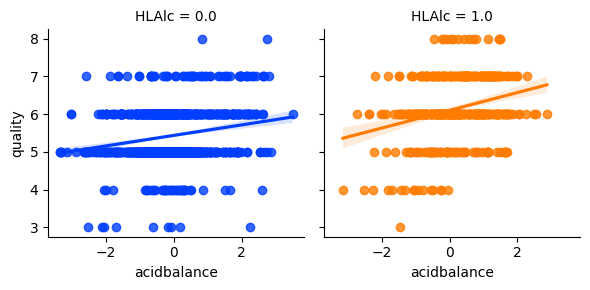

In [94]:
#g = sns.FacetGrid(X_qual, col='binned.alcohol', hue='binned.alcohol', palette="viridis")
#g.map(sns.regplot, "sulphates", "quality")

g = sns.FacetGrid(data=X, col="HLAlc", hue="HLAlc", palette="bright")
g.map(sns.regplot, "acidbalance", "quality")

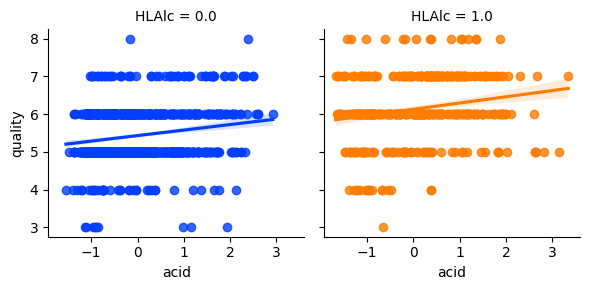

In [95]:
g = sns.FacetGrid(data=X, col="HLAlc", hue="HLAlc", palette="bright")
g.map(sns.regplot, "acid", "quality")

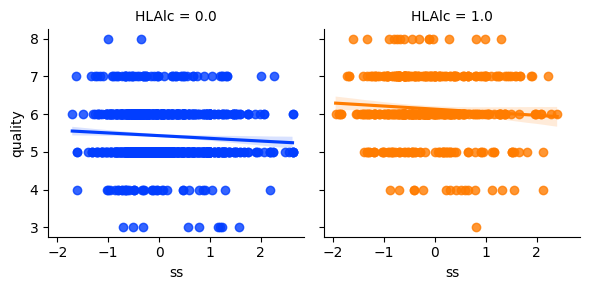

In [96]:
g = sns.FacetGrid(data=X, col="HLAlc", hue="HLAlc", palette="bright")
g.map(sns.regplot, "ss", "quality")

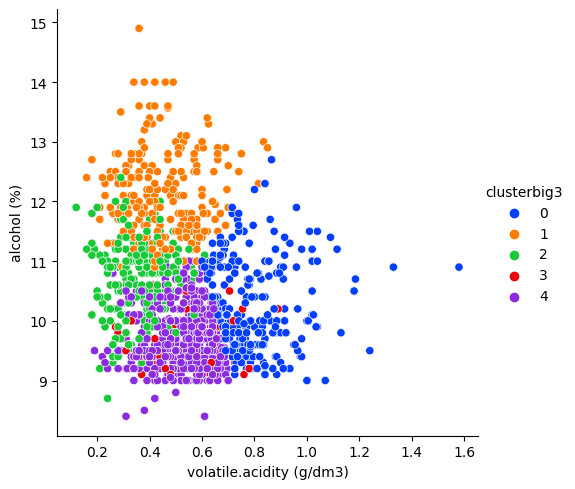

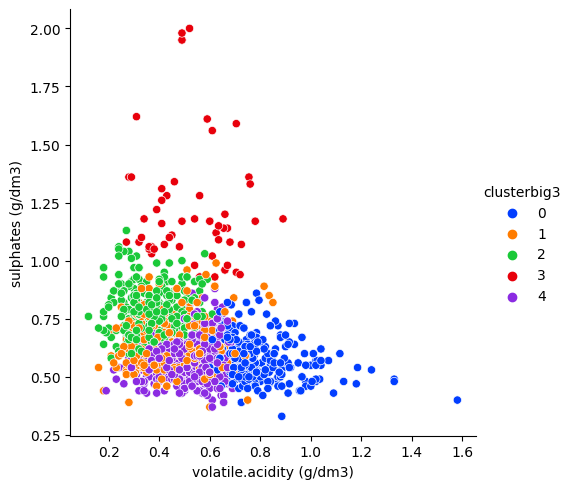

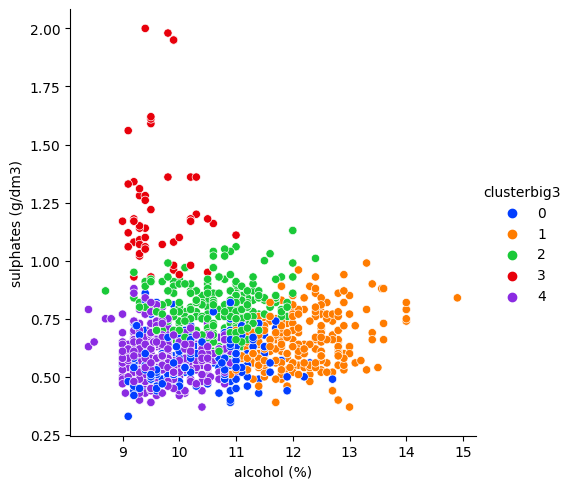

In [60]:
sns.relplot(x="volatile.acidity (g/dm3)", y="alcohol (%)", hue="clusterbig3", palette="bright", data=data)
sns.relplot(x="volatile.acidity (g/dm3)", y="sulphates (g/dm3)", hue="clusterbig3", palette="bright", data=data)
sns.relplot(x="alcohol (%)", y="sulphates (g/dm3)", hue="clusterbig3", palette="bright", data=data)

<AxesSubplot:xlabel='clusterbig3', ylabel='quality'>

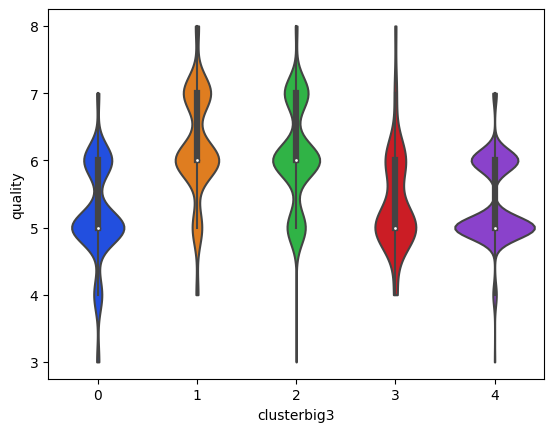

In [61]:
sns.violinplot(data=data, x="clusterbig3", y="quality", cut=0, scale="area", inner="box")

Now let's group by the clusters and look at acid balance within each cluster with radar plots.

In [85]:
data["GoodBad"] = ((np.sign(data["quality"]-6.5)+1.)/2.)
data_gd = data.loc[data["GoodBad"]==1., :]
data_bd = data.loc[data["GoodBad"]==0., :] 
data_cl_mean_gd = data_gd.groupby("clusterbig3").mean()
data_cl_mean_bd = data_bd.groupby("clusterbig3").mean()
#print(data_cl_mean.head(10))
data_cl_max_gd = data_gd.groupby("clusterbig3").max()
data_cl_max_bd = data_bd.groupby("clusterbig3").max()
data_cl_min_gd = data_gd.groupby("clusterbig3").min()
data_cl_min_bd = data_bd.groupby("clusterbig3").min()
data_cl_rdr_gd = (data_cl_mean_gd - data_cl_min_gd)/(data_cl_max_gd - data_cl_min_gd)
data_cl_rdr_bd = (data_cl_mean_bd - data_cl_min_bd)/(data_cl_max_bd - data_cl_min_bd)
print(data_cl_rdr_gd.head())
#data_cl_rdr_gd = data_cl_rdr.loc[data_cl_rdr["GoodBad"]==1., :]

             fixed.acidity (g/dm3)  volatile.acidity (g/dm3)  \
clusterbig3                                                    
0                         0.201587                  0.428571   
1                         0.390159                  0.424554   
2                         0.426593                  0.313324   
3                         0.364780                  0.388889   
4                         0.281481                  0.585859   

             citric.acid (g/dm3)  residual.sugar (g/dm3)  chlorides (g/dm3)  \
clusterbig3                                                                   
0                       0.196911                0.228571           0.310406   
1                       0.526994                0.252395           0.503804   
2                       0.475877                0.418086           0.477788   
3                       0.533333                0.444444           0.421941   
4                       0.337542                0.413743           0.347475  

In [51]:
# Try radar plots following https://www.pythoncharts.com/matplotlib/radar-charts/
# This code successfully produces a radar plot!

def radar_prep_data(df, var_labels, index, radar_max=100):
    
    new_max = radar_max
    new_min = 0
    new_range = new_max - new_min
    num_vars = len(var_labels)

    angles = np.linspace(0, 2*np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]
     
    dfinter = df[var_labels].copy()
    adjusted = [label+'_adj' for label in var_labels]
    for factor in var_labels:
        max_val = dfinter[factor].max()
        min_val = dfinter[factor].min()
        val_range = max_val - min_val
        dfinter[factor+'_adj'] = (((dfinter.loc[:,factor] - min_val)*new_range)/val_range+new_min)
        
    dft = dfinter.loc[:, adjusted]
    
    angles = np.linspace(0, 2*np.pi, num_vars, endpoint=False).tolist()
    values = dft.loc[index].tolist()
    values += values[:1]
    angles += angles[:1]
    #print(values)
    
    return [dft, values, angles]

    
def radar_make_plot(dft, index, values, angles, color="blue", radar_max=100):
    
    # run the below lines of code first
    #fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    #ax.plot(angles, values, color='blue', linewidth=1)
    
    
    labels = dft.columns
    num_vars = dft.shape[1]
    try:
        lax = len(ax)
    except TypeError:
        lax = 0
        
    if lax > 0:
    #print(angles, values)
    #ax[0,0].fill(angles, values, color=[0, 0.5, 0], alpha=0.25)
    #ax[0,0].set_theta_offset(np.pi/2.)
    #ax[0,0].set_theta_direction(-1)
    #ax[0,0].set_thetagrids(np.degrees(angles[:-1]), labels)
        ax.reshape(-1)[0].fill(angles, values, color=color, alpha=0.25)
        ax.reshape(-1)[0].set_theta_offset(np.pi/2.)
        ax.reshape(-1)[0].set_theta_direction(-1)
        ax.reshape(-1)[0].set_thetagrids(np.degrees(angles[:-1]), labels)
        
        my_zip = zip(ax[0,0].get_xticklabels(), angles)

    else:
        ax.fill(angles, values, color=color, alpha=0.25)
        ax.set_theta_offset(np.pi/2.)
        ax.set_theta_direction(-1)
        ax.set_thetagrids(np.degrees(angles[:-1]), labels)
        
        my_zip = zip(ax.get_xticklabels(), angles)
        
    for label, angle in my_zip:
        if angle in (0, np.pi):
            label.set_horizontalalignment("center")
        elif 0 < angle < np.pi:
            label.set_horizontalalignment('left')
        else:
            label.set_horizontalalignment('right')
        
    #ax[0,0].set_ylim(0, radar_max)
    no_labs = ["" for i in labels]
    if lax > 0:
        for a in ax.reshape(-1):
            a.set_theta_offset(np.pi/2.)
            a.set_theta_direction(-1)
            a.set_thetagrids(np.degrees(angles[:-1]), labels)
            a.set_ylim(0, radar_max)
            #a.set_rlabel_position(180/num_vars)

    else:
        ax.set_theta_offset(np.pi/2.)
        ax.set_theta_direction(-1)
        ax.set_thetagrids(np.degrees(angles[:-1]), labels)
        ax.set_ylim(0, radar_max)
        

def add_to_radar(df, ind, index_list, angles, color):
    
    ind_df = index_list[ind]
    values =  df.loc[ind_df].tolist()
    values += values[:1]
    
    try:
        len(ax)
        ncols = ax.shape[1]
        ax[ind//ncols, ind%ncols].plot(angles, values, color=color, linewidth=1, label=str(ind))
        ax[ind//ncols, ind%ncols].fill(angles, values, color=color, alpha=0.25)
    
    except TypeError:
        ax.plot(angles, values, color=color, linewidth=1, label=str(ind))
        ax.fill(angles, values, color=color, alpha=0.25)


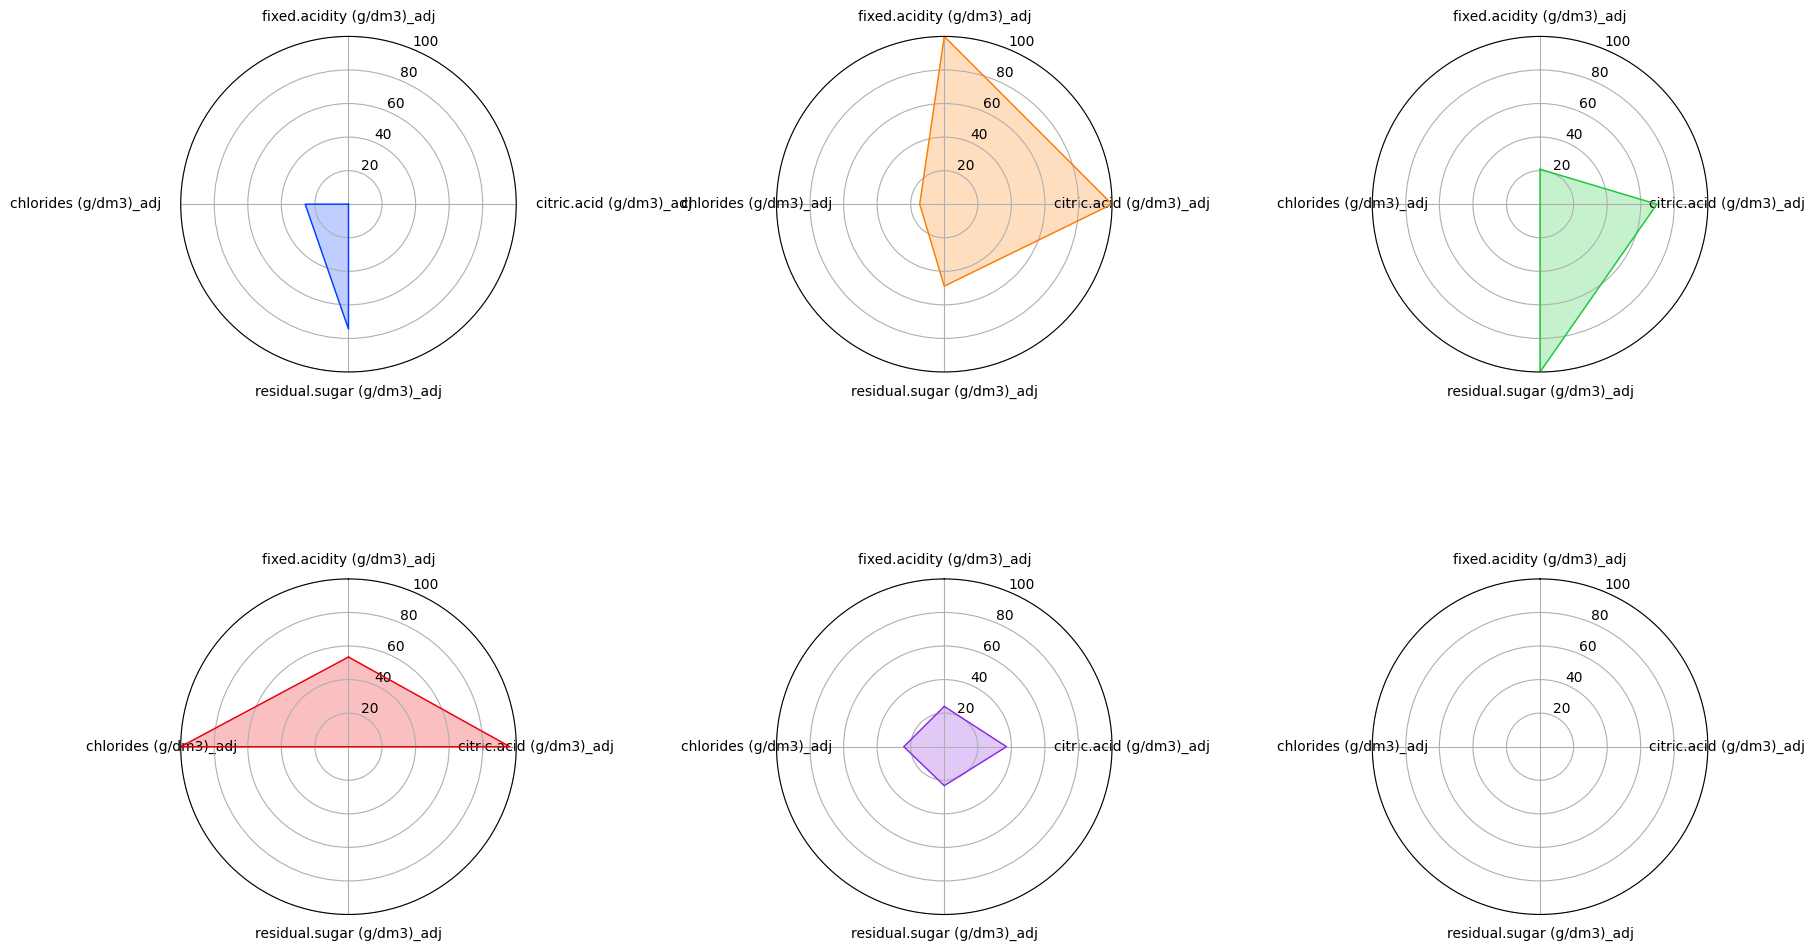

In [54]:
acidbalance = ["fixed.acidity (g/dm3)", "citric.acid (g/dm3)", "residual.sugar (g/dm3)", "chlorides (g/dm3)"]
dft, values, angles = radar_prep_data(data_cl, acidbalance, 0)

fig, ax = plt.subplots(2, 3, figsize=(18, 11), subplot_kw=dict(polar=True))
ax[0, 0].plot(angles, values, color=sns.color_palette("bright")[0], linewidth=1)

radar_make_plot(dft, 0, values, angles, color=sns.color_palette("bright")[0] )
add_to_radar(dft, 1, np.arange(5), angles, sns.color_palette("bright")[1])
add_to_radar(dft, 2, np.arange(5), angles, sns.color_palette("bright")[2])
add_to_radar(dft, 3, np.arange(5), angles, sns.color_palette("bright")[3])
add_to_radar(dft, 4, np.arange(5), angles, sns.color_palette("bright")[4])
plt.tight_layout()

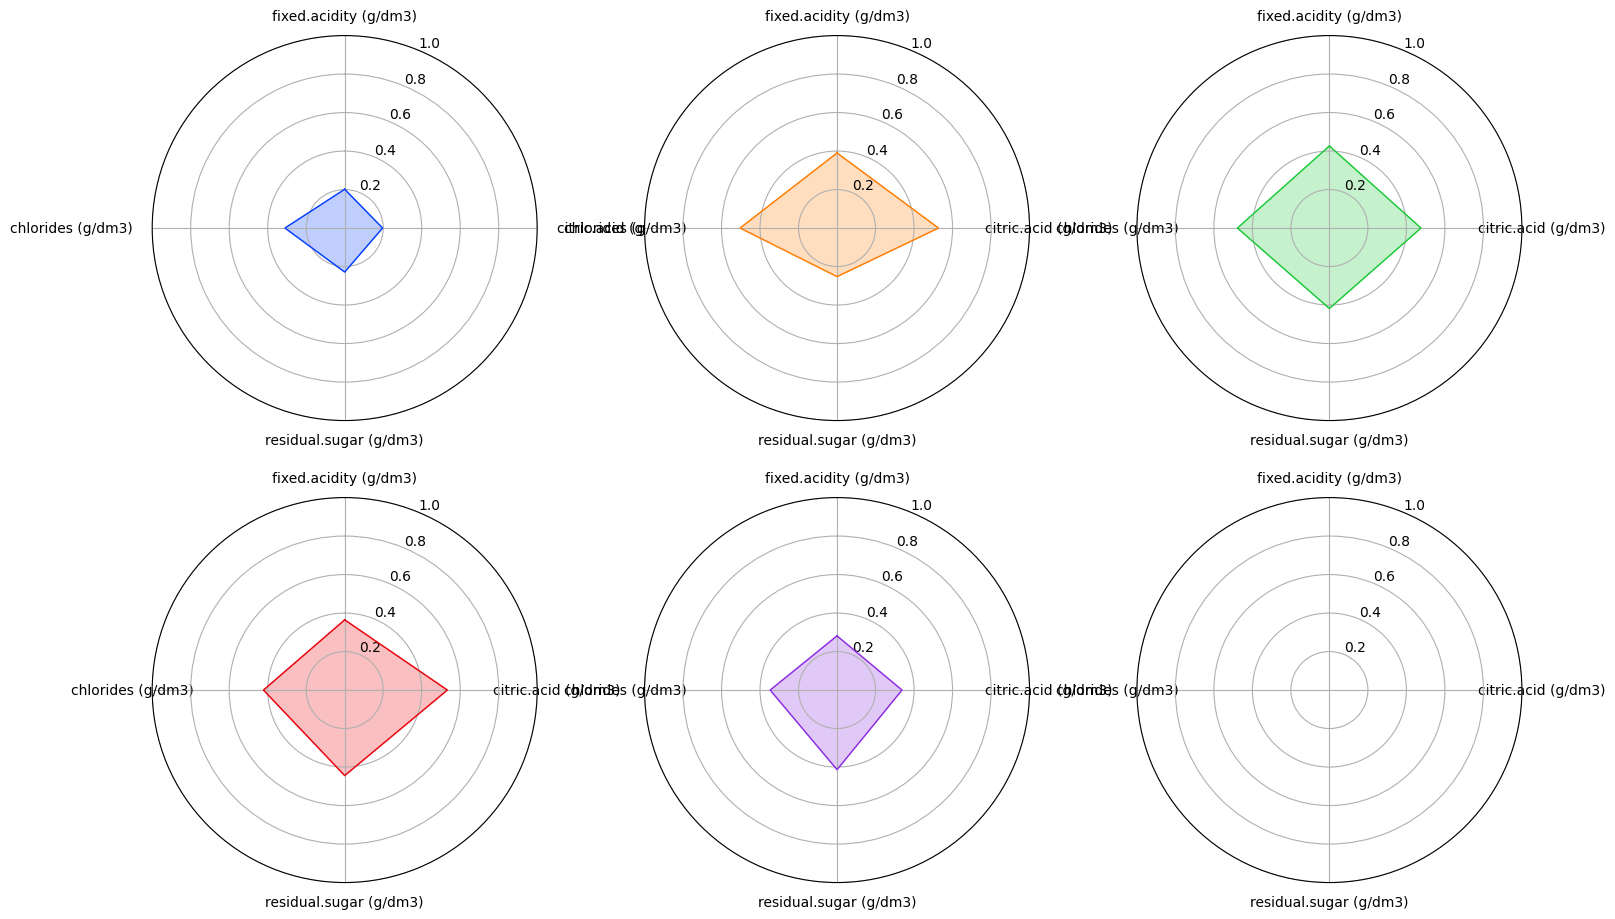

In [86]:
angles = np.linspace(0, 2*np.pi, len(acidbalance), endpoint=False).tolist()
values = data_cl_rdr_gd.loc[0, acidbalance].tolist()
values += values[:1]
angles += angles[:1]
#print(values)
#print(angles)

fig, ax = plt.subplots(2, 3, figsize=(18, 11), subplot_kw=dict(polar=True))
ax[0, 0].plot(angles, values, color=sns.color_palette("bright")[0], linewidth=1)
radar_make_plot(data_cl_rdr_gd.loc[:,acidbalance], 0, values, angles, color=sns.color_palette("bright")[0], radar_max=1)
add_to_radar(data_cl_rdr_gd.loc[:,acidbalance], 1, np.arange(5), angles, sns.color_palette("bright")[1])
add_to_radar(data_cl_rdr_gd.loc[:,acidbalance], 2, np.arange(5), angles, sns.color_palette("bright")[2])
add_to_radar(data_cl_rdr_gd.loc[:,acidbalance], 3, np.arange(5), angles, sns.color_palette("bright")[3])
add_to_radar(data_cl_rdr_gd.loc[:,acidbalance], 4, np.arange(5), angles, sns.color_palette("bright")[4])

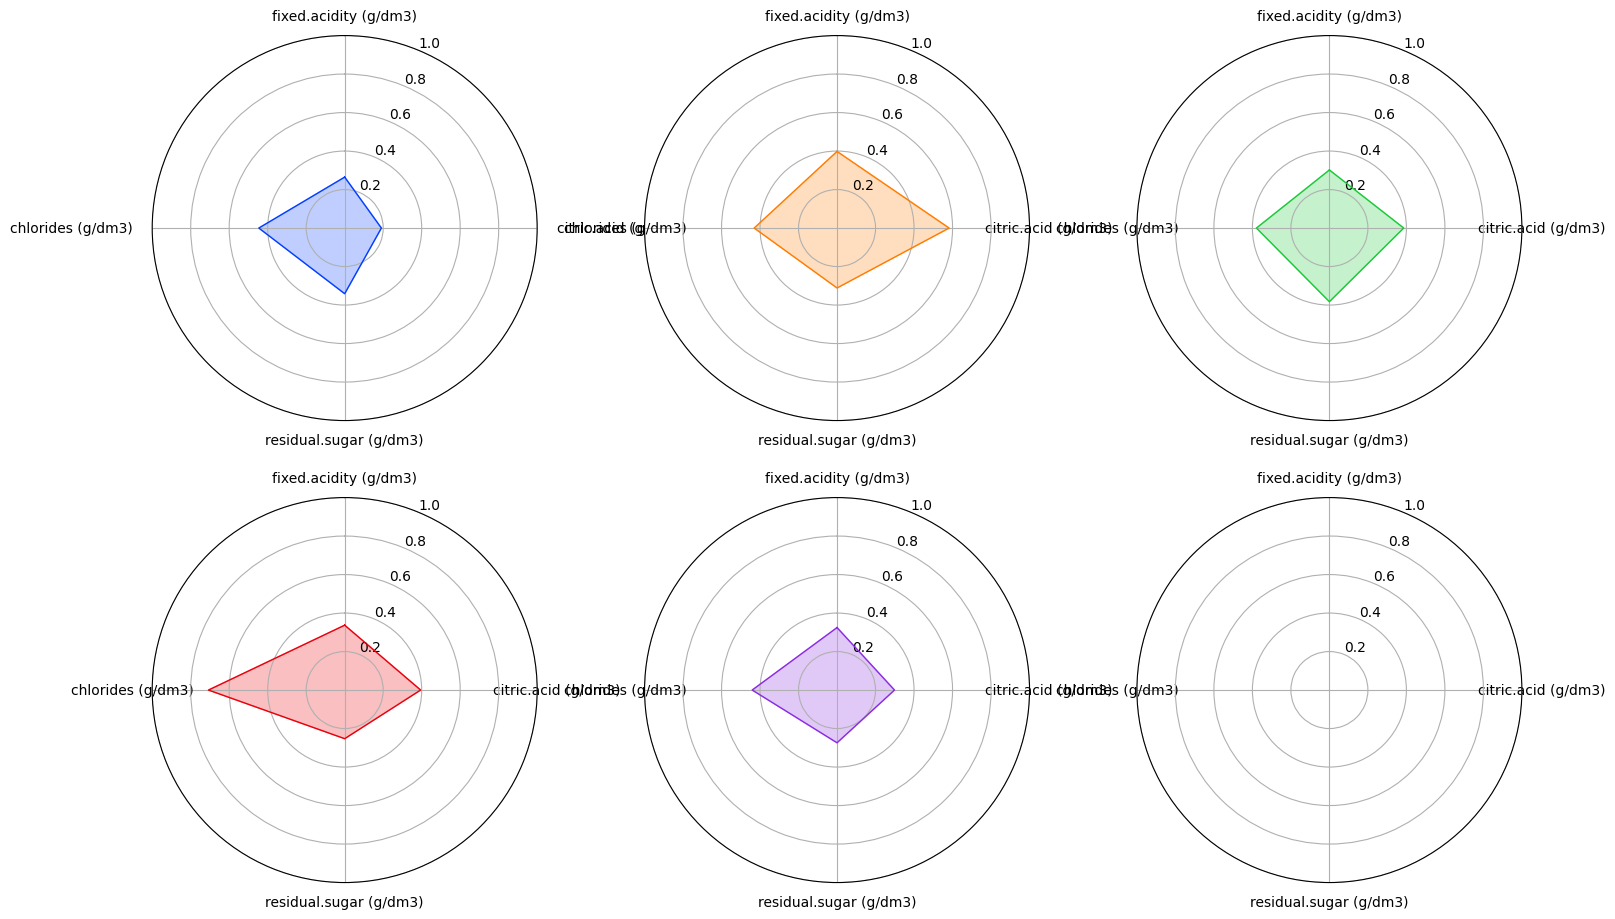

In [87]:
angles = np.linspace(0, 2*np.pi, len(acidbalance), endpoint=False).tolist()
values = data_cl_rdr_bd.loc[0, acidbalance].tolist()
values += values[:1]
angles += angles[:1]
#print(values)
#print(angles)

fig, ax = plt.subplots(2, 3, figsize=(18, 11), subplot_kw=dict(polar=True))
ax[0, 0].plot(angles, values, color=sns.color_palette("bright")[0], linewidth=1)
radar_make_plot(data_cl_rdr_bd.loc[:,acidbalance], 0, values, angles, color=sns.color_palette("bright")[0], radar_max=1)
add_to_radar(data_cl_rdr_bd.loc[:,acidbalance], 1, np.arange(5), angles, sns.color_palette("bright")[1])
add_to_radar(data_cl_rdr_bd.loc[:,acidbalance], 2, np.arange(5), angles, sns.color_palette("bright")[2])
add_to_radar(data_cl_rdr_bd.loc[:,acidbalance], 3, np.arange(5), angles, sns.color_palette("bright")[3])
add_to_radar(data_cl_rdr_bd.loc[:,acidbalance], 4, np.arange(5), angles, sns.color_palette("bright")[4])

In [53]:
sns.color_palette("bright")[4]
my_pal = [sns.color_palette("PiYG")[0], sns.color_palette("PiYG")[1], sns.color_palette("PiYG")[4], sns.color_palette("PiYG")[5]]

In [7]:
std_scaler = StandardScaler()
X_cols = data.columns
X = std_scaler.fit_transform(data)
X = pd.DataFrame(X, columns=X_cols)

kmeans3 = KMeans(n_clusters=3)
kmeans4 = KMeans(n_clusters=4)
kmeans5 = KMeans(n_clusters=4)
data["clusteracid"] = kmeans3.fit_predict(X[["volatile.acidity (g/dm3)", "fixed.acidity (g/dm3)", "citric.acid (g/dm3)"]])
data["clusterss"] = kmeans4.fit_predict(X[["residual.sugar (g/dm3)", "chlorides (g/dm3)"]])
data["clusterssacid"] = kmeans5.fit_predict(X[["fixed.acidity (g/dm3)",
                                               "citric.acid (g/dm3)","residual.sugar (g/dm3)", "chlorides (g/dm3)"]])

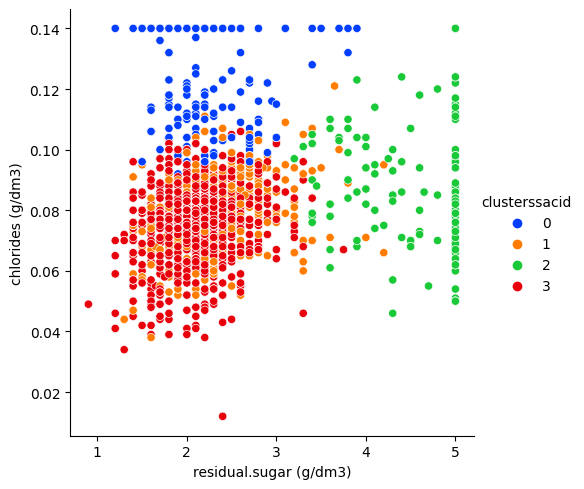

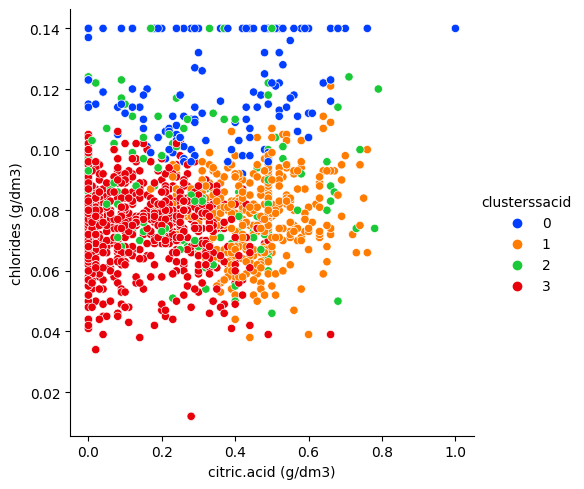

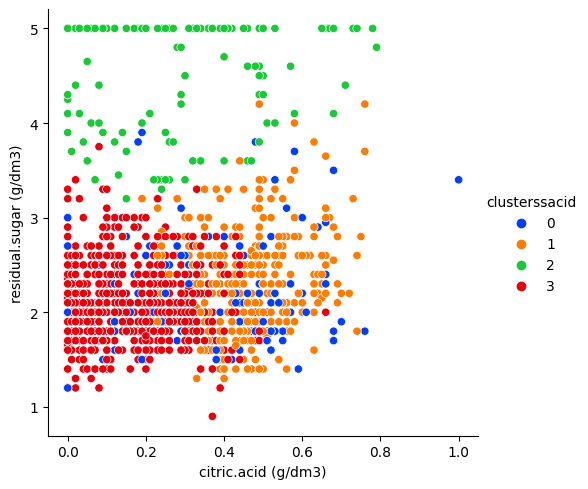

In [8]:
#sns.relplot(x="volatile.acidity (g/dm3)", y="citric.acid (g/dm3)", hue="clusteracid", palette='PuRd', data=data)
#sns.relplot(x="fixed.acidity (g/dm3)", y="citric.acid (g/dm3)", hue="clusteracid", palette='PuRd', data=data)
#sns.relplot(x="volatile.acidity (g/dm3)", y="fixed.acidity (g/dm3)", hue="clusteracid", palette='PuRd', data=data)
sns.relplot(x="residual.sugar (g/dm3)", y="chlorides (g/dm3)", hue="clusterssacid", palette="bright", data=data)
sns.relplot(x="citric.acid (g/dm3)", y="chlorides (g/dm3)", hue="clusterssacid", palette="bright", data=data)
sns.relplot(x="citric.acid (g/dm3)", y="residual.sugar (g/dm3)", hue="clusterssacid", palette="bright", data=data)

<AxesSubplot:xlabel='clusterssacid', ylabel='quality'>

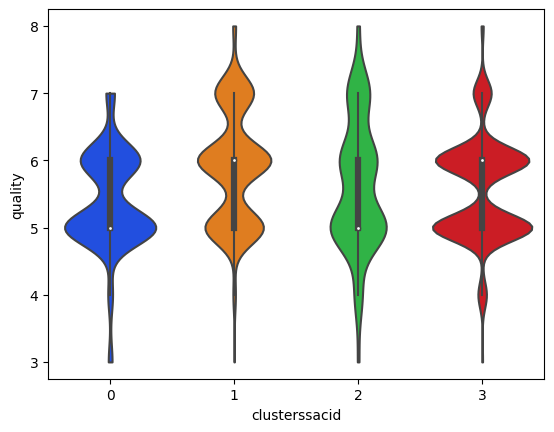

In [9]:
sns.violinplot(data=data, x="clusterssacid", y="quality", cut=0, scale="area", inner="box")
#sns.violinplot(data=data, x="clusterssacid", y="quality", cut=0, scale="area", inner="stick")

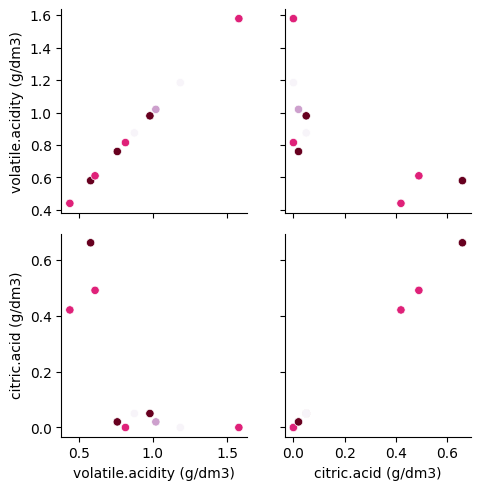

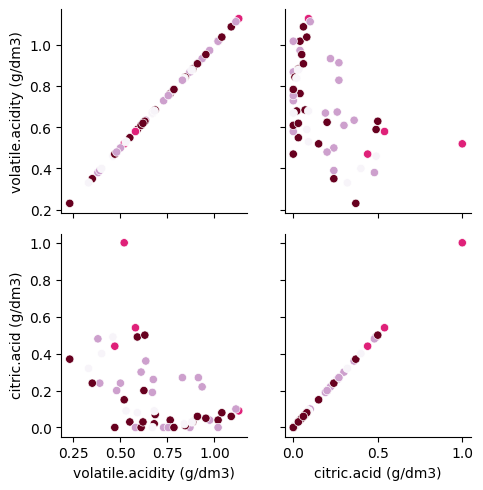

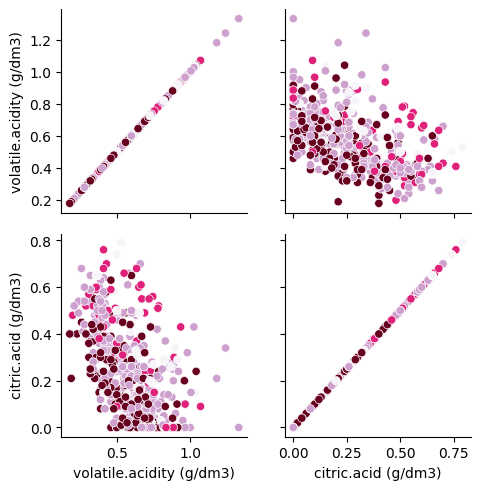

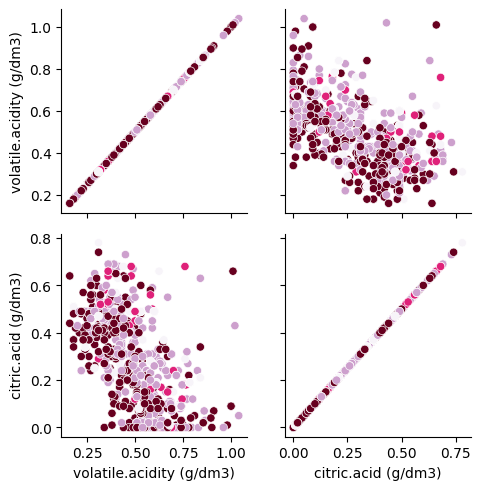

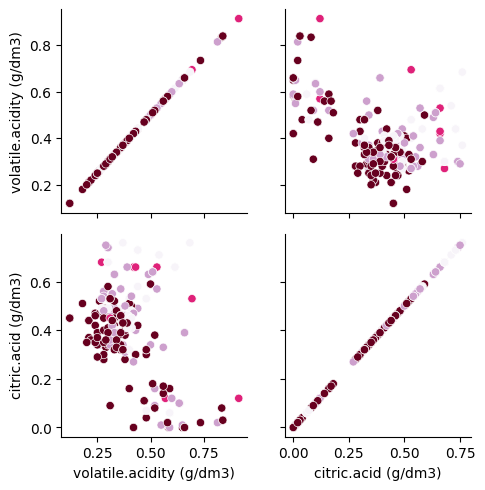

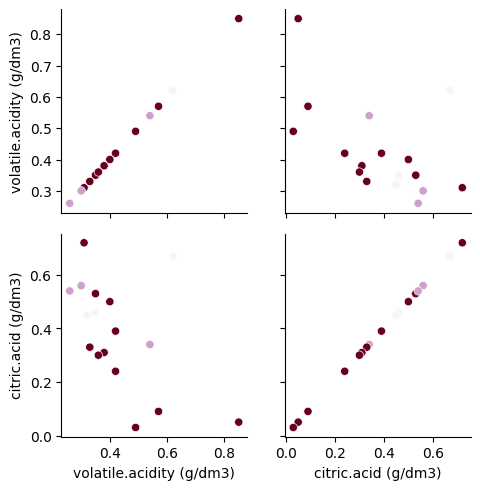

In [10]:
size = 4
#sns.jointplot(x=data["fixed.acidity"], y=data["volatile.acidity"], kind='scatter', hue=np.sign(data["quality"]-6.5), palette="bright", height=size)
for i in range(3,9):
    g=sns.PairGrid(data.loc[data["quality"]==i], vars=["volatile.acidity (g/dm3)", "citric.acid (g/dm3)"],
                   #hue="clusteracid", palette=[sns.color_palette("bright")[i-3]])
                   hue="clusterss", palette="PuRd")
    g.map(sns.scatterplot)
#g=sns.PairGrid(data.loc[data["quality"]==], vars=["volatile.acidity (g/dm3)", "citric.acid (g/dm3)"],
#               hue="quality", palette=[sns.color_palette("bright")[2]])
#g.map(sns.scatterplot)
#sns.jointplot(x=data.loc[data["volatile.acidity (g/dm3)"]<0.4, "volatile.acidity (g/dm3)"],
#              y=data.loc[data["volatile.acidity (g/dm3)"]<0.4, "citric.acid (g/dm3)"],
#              hue=data["quality"], palette="bright", kind='kde')

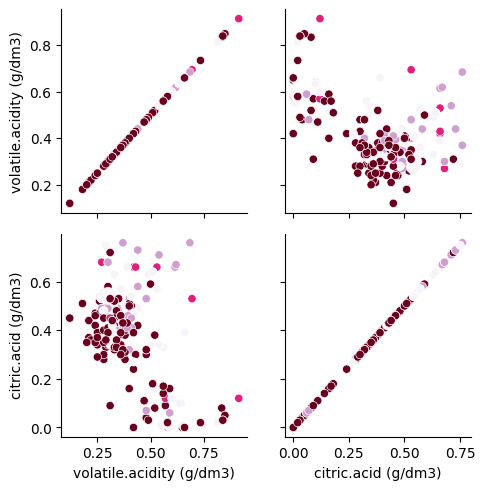

In [109]:
g=sns.PairGrid(data.loc[data["quality"]>6.5], vars=["volatile.acidity (g/dm3)", "citric.acid (g/dm3)"],
               #hue="clusteracid", palette=[sns.color_palette("bright")[i-3]])
               hue="clusterss", palette="PuRd")
g.map(sns.scatterplot)

In [177]:
my_pal = [sns.color_palette("PiYG")[0], sns.color_palette("PiYG")[1], sns.color_palette("PiYG")[4], sns.color_palette("PiYG")[5]] 

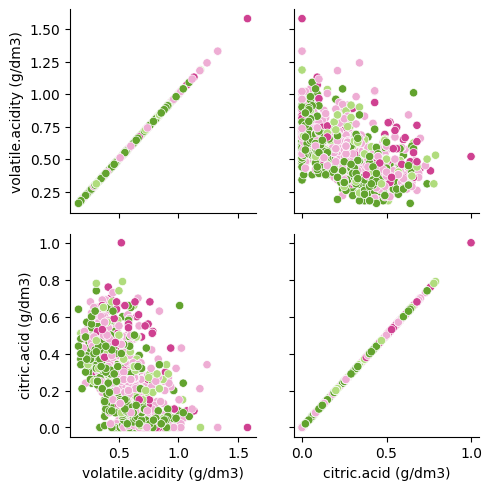

In [178]:
g=sns.PairGrid(data.loc[data["quality"]<6.5], vars=["volatile.acidity (g/dm3)", "citric.acid (g/dm3)"],
               #hue="clusteracid", palette=[sns.color_palette("bright")[i-3]])
               hue="clusterss", palette=my_pal)
g.map(sns.scatterplot)

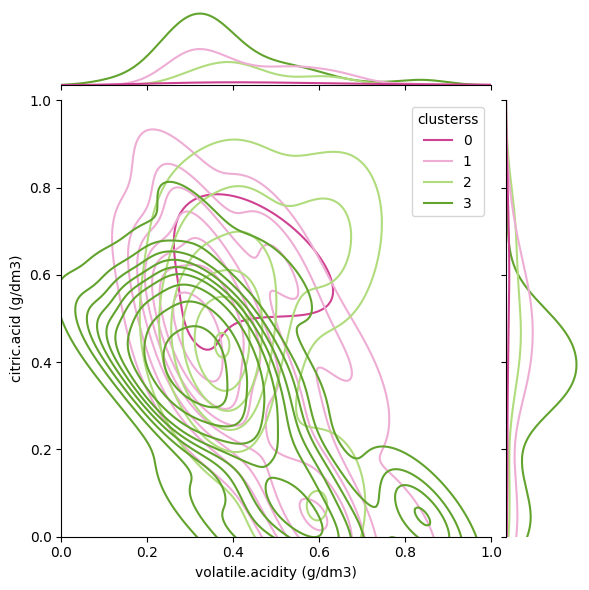

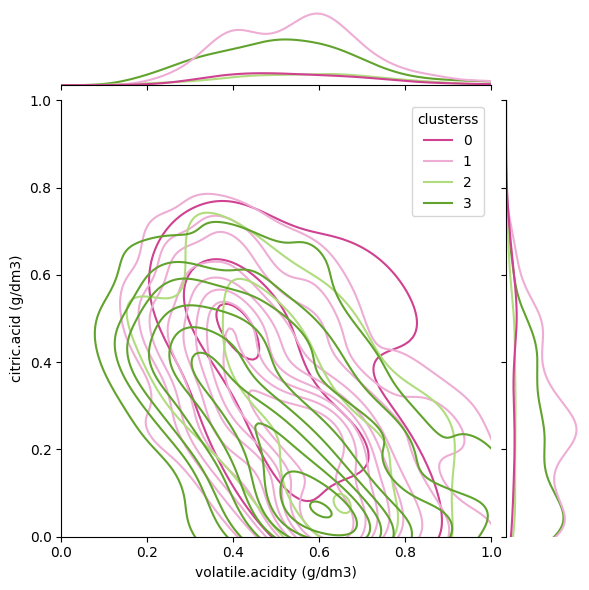

In [179]:
goodinds = data[data["quality"] > 6.5].index
sns.jointplot(x=data.loc[goodinds,"volatile.acidity (g/dm3)"],
              y=data.loc[goodinds,"citric.acid (g/dm3)"],
              palette=my_pal, hue=data.loc[goodinds, "clusterss"], xlim=[0, 1], ylim=[0, 1], kind='kde')

badinds = data[data["quality"] < 6.5].index
sns.jointplot(x=data.loc[badinds,"volatile.acidity (g/dm3)"],
              y=data.loc[badinds,"citric.acid (g/dm3)"],
              palette=my_pal, hue=data.loc[badinds, "clusterss"], xlim=[0, 1], ylim=[0, 1], kind='kde')

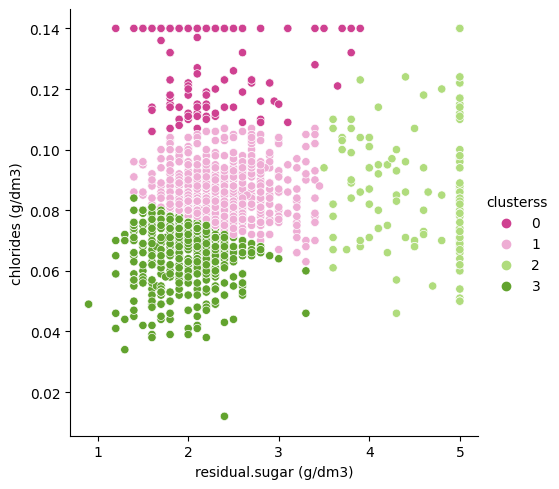

In [182]:
sns.relplot(x="residual.sugar (g/dm3)", y="chlorides (g/dm3)", hue="clusterss", palette=my_pal, data=data)

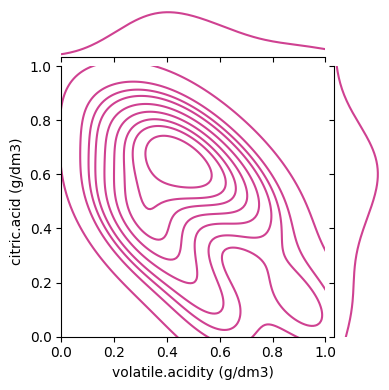

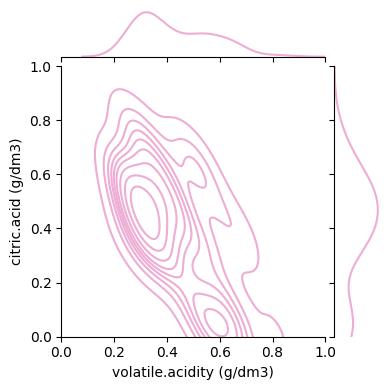

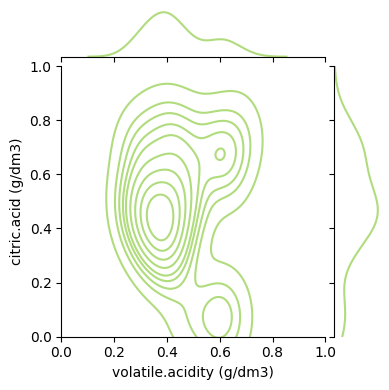

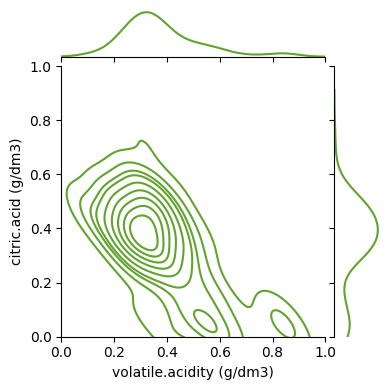

In [176]:
goodinds = [data[(data["quality"] > 6.5) & (data["clusterss"] ==i)].index for i in range(4)]
my_pal = [sns.color_palette("PiYG")[0], sns.color_palette("PiYG")[1], sns.color_palette("PiYG")[4], sns.color_palette("PiYG")[5]] 
for i in range(4):
    sns.jointplot(x=data.loc[goodinds[i],"volatile.acidity (g/dm3)"],
                  y=data.loc[goodinds[i],"citric.acid (g/dm3)"],
                  color=my_pal[i], xlim=[0, 1], ylim=[0, 1], kind='kde', height=4)

More sources:
    https://www.compoundchem.com/2016/02/25/a-guide-to-common-fruit-acids/
    https://www.guildsomm.com/public_content/features/articles/b/jamie_goode/posts/the-taste-of-wine-acid-sweetness-and-tannin
        